### P2: Baseball Managers
Thomas Hrabchak <br>
March 2016

### Introduction
Major League Baseball (MLB) is known for its all-stars making multi million dollar salaries and hitting towering homeruns. Often overlooked is the manager, who rarely leaves the duggout except to argue with an umpire, throw his hat, and get ejected from the game. Some managers are well known, have winning teams, and make it into the hall of fame, many others are forgotten by fans.

Behind the scenes there are many decisions being made by the manager every pitch, such as the positioning of fielders, preparation of a relief pitcher, or if the batter should try to bunt. These decisions do affect the outcome of the game and cumulatively the season. However, the results of managerial decisions manifest themselves in the performance of the players which makes directly measuring the performance of the manager difficult. 

Additionally, managers have responsibilities that are unrelated to or indirectly related to winning games, such as interacting with the media. This paper will not take into consideration skills which do not affect team statistics, although extraneous, non-baseball related skills are relevant to assessing the overall performance of managers.

#### Background
Methods for assessing the performance of baseball managers have been proposed in several academic papers. The most popular method is James's (1986) "Pythagorean theorem", in which a manager's performance is assessed using an estimation of expected wins. Additionally, Bradbury (2006) assesses a manager in terms of impact on player performance.

In 2014, Randy Silvers and Raul Susmel explored the compensation of managers in their paper "Compensation of a Manager: The Case of Major League Baseball". Instead of attempting to directly assess the performance of a manager using a metric derived from baseball statistics, they hypothesized that the economic market of baseball managers would result in the best performing managers (highest team winning percentage and number of playoff appearances) being compensated the highest salaries. The results of their analysis showed that a manager's past performance affects the manager's current salary, but the manager's current salary does not affect the current performance of the manager's team. Silvers and Susmel note that in efficient markets the compensation of a manager is a sufficient measure of his expected productivity but in this case has been shown to be insignificant in predicting any team performance metric. This implies that the market of MLB managers is not efficient.

Based on Silvers and Susmel and the previous papers, it seems as if there is still room for improvement in understanding the role of an MLB manager and the impact they have on the performance of their team.

### Questions
There are many possible questions about MLB managers, assesing their performance, and assessing their impact on their team. To limit the scope of this paper, only the following question will be explored:

- When a manager transfers teams, does the relative performance of any team statistic from the manager's previous team transfer to the manager's new team?

#### Alternative Questions
Below are other questions which I considered addressing in this paper. However they need further refinement in order to be actionable.
- How important is having a good manager to the success of a major league baseball team?
- Which, if any, team statistics correlate with the winningest managers?
- What are characteristics of managers that make it into the hall of fame?
- What are characteristics of managers that have short careers?
- Are any managers particularly good in the post season?
- Do any team statistics correlate with a long managerial career?
- Who is the most recent player manager and what were the circumstances?
- Are there any trends in the salaries of managers?
- Has a 'bad' manager ever won the world series? In other words, has a team performed so well as to compensate for having a less than ideal manager?

### Wrangle
The data for this project comes from the 2014 edition of The Lahman Baseball Database. We will need to refine the data from this source to better address our question.

The Lahman Baseball Database contains all the required information necessary for this project in the Teams and Managers tables. However we will need to transform the data into new tables in order to make the data more accessible for our exploration and analysis. We first determine the relative performance for each team statistic for each year and append the values as columns to the existing Teams table. We then filter the Managers table to only include managers that remained with the same team for the whole year. This is because we are unable to divide up the team statistics table into segments attributable to different managers within the same season. We then create a new table containing manager stints, in which a stint is a collection of consecutive seasons a manager remained with the same team (and lasted the full year). We then create functions which help describe the relative performances of each statistic in each stint. We can then create a table of manager transitions, in which a manger transfers from a stint on one team to a stint on another. Finally we create functions which produce descriptive statistics comparing the relative performance of a statistic in the before stint to the relative performance of the same statistic in the after stint.

In terms of missing data, the Teams table is incomplete for every row. Notably it is missing team statistics from the columns SB, CS, HBP, SF, and DP. In this paper, we will not look at these team statistics because it would introduce error if we compared years in which these statistics were recordered and years in which they were not recorded. For the Managers table, we select only managers which fulfill all the required criteria in our filtering of Managers step (step 3). This means that in our output, we are certain that we have all the required information that we need.

As an overview, below is a summary of the steps we will take in the data wrangling phase.
1. Import relevant data from The Lahman Baseball Database.
2. Appened relative performance (rank) for each team statistic for each year to teams_df.
3. Filter mangers_df to only include managers that lasted the full year.
4. Create table of manager stints.
5. Aggregate the relative performance of each team statistic for each stint.
6. Create table containing manager stint transitions.
7. Append the differences of each statistic created in step 5 to the table of manager stint transitions (created in step 6).

#### 1. Import Data
This project uses data from the 2014 edition of The Lahman Baseball Database, hosted on GitHub.

In [1]:
# Import Libraries and Data
from scipy import stats
import scikitsbootstrap as bootstrap  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
plt.style.use('ggplot')
%pylab inline

repository = "https://raw.githubusercontent.com/thrabchak/Udacity-Data-Analysis/"
folder = "master/P2%20Baseball%20Managers/data/"

managers_df = pd.read_csv(repository + folder + "Managers.csv")
teams_df    = pd.read_csv(repository + folder + "Teams.csv")

def print_df_columns(df):
    """Print columns of DataFrame df."""
    print(np.array_str(df.columns))

# Show columns of the imported DataFrames
print("Managers: ")
print_df_columns(managers_df)
print("Teams: ")
print_df_columns(teams_df)

Populating the interactive namespace from numpy and matplotlib
Managers: 
['playerID' 'yearID' 'teamID' 'lgID' 'inseason' 'G' 'W' 'L' 'rank'
 'plyrMgr']
Teams: 
['yearID' 'lgID' 'teamID' 'franchID' 'divID' 'Rank' 'G' 'Ghome' 'W' 'L'
 'DivWin' 'WCWin' 'LgWin' 'WSWin' 'R' 'AB' 'H' '2B' '3B' 'HR' 'BB' 'SO'
 'SB' 'CS' 'HBP' 'SF' 'RA' 'ER' 'ERA' 'CG' 'SHO' 'SV' 'IPouts' 'HA' 'HRA'
 'BBA' 'SOA' 'E' 'DP' 'FP' 'name' 'park' 'attendance' 'BPF' 'PPF'
 'teamIDBR' 'teamIDlahman45' 'teamIDretro']


#### 2. Team Statistic Overall Relative Performance
We want to append the relative statistical performance of teams to the existing teams_df DataFrame.

Relative statistical perfomance is a team's performance for a given statistic in respect to all other teams for that year. For example, the team with the most wins in a given year performed the best for that statistic ("W") and would be given a relative statistical performance ("rel_W") of 1. The team with the second most wins would be given a 2. If two teams have the same value for a given statistic, they will share the same value for relative statistical performance. For example if two teams shared the same number of wins, and that number of wins was the most for that season, both teams would share the relative statistical performance of 1. In this case, the team with the next most number of wins would be given a relative statistical performance of 3, because 2 other teams performed better. The team_stat dictionary contains the information for how a statistic should be ordered, either largest to smallest (True) or smallest to largest (False).

In [2]:
# Create a dictionary to determine how each statistic should be ordered.
# The key is the statistic and the value is True if it should be ordered from
# largest to smallest, False if it should be ordered smallest to largest.
team_stat = {
    # Overall Statistics
    'Rank':   False, # Position in final standings
    "W":      True,  # Wins
    "L":      False, # Losses
    
    # Batting Statistics
    "R":      True,  # Runs scored
    "H":      True,  # Hits
    "2B":     True,  # Doubles
    "3B":     True,  # Triples
    "HR":     True,  # Homeruns
    "BB":     True,  # Walks
    "SO":     False, # Strikeouts
    
    # Pitching Statistics
    "RA":     False, # Opponents run scored
    "ER":     False, # Earned runs allowed
    "ERA":    False, # Earned run average
    "CG":     True,  # Complete games pitched
    "SHO":    True,  # Shutouts
    "SV":     True,  # Saves
    "HA":     False, # Hits allowed
    "HRA":    False, # Homeruns allowed
    "BBA":    False, # Walks allowed
    "SOA":    True,  # Strikeouts by pitchers
    
    # Fielding Statistics
    "E":      False, # Errors
    "FP":     True   # Fielding percentage
}

# Initialize data structure which we will create a DataFrame from
def create_data_structure():
    """Returns the structure for a dictionary with team stats as keys and 
    lists as values.
    stat -> []"""
    # Create list of columns
    columns = ['yearID', 'teamID']
    for key in team_stat.keys():
        columns.append('rel_' + key)
        
    # Create 2D array for data
    data = {}
    for column in columns:
        data[column] = []
        
    return data

def team_positions_for_stat(my_teams_df, year, stat):
    """Returns an ordered dictionary containing the relative positional data for a 
    team's statistic. The returned dictionary will take the form of:
    rel_position -> [stat_value, team1, team2]
    Example: {1:[10, BOS], 2:[5, NYY, MIN], 4:[3, MIA], ...}"""
    # rel_position -> [stat_value, team1, team2]
    placement_dict = collections.OrderedDict() 
    
    # Create an ordered list of teams in this year for this statistic
    sorted_df = my_teams_df[my_teams_df.yearID == year].\
                    sort_values(stat, ascending=(not team_stat[stat]))
    rel_place = 1
    team_counter = 1
    placement_dict[1] = [sorted_df.iloc[0][stat], sorted_df.iloc[0].teamID]
    for i in range(1, len(sorted_df)):
        value = sorted_df.iloc[i][stat]
        team = sorted_df.iloc[i].teamID
        team_counter += 1
        if placement_dict[rel_place][0] == value or pd.isnull(value):
            placement_dict[rel_place].append(team)
        else:            
            placement_dict[team_counter] = [value, team]
            rel_place = team_counter
        
    return placement_dict    

def rel_stats_for_year(my_teams_df, year):
    """Returns a dictionary of dictionaries for this year given my_teams_df.
    The return dictionary will take the form of:
    team -> {stat -> rel_place}
    Example: {'BOS': {'W': 1, 'SO': 3, ...}, 'NYY': {'W': 5, 'SO': 1, ...}, ...}"""
    # Create teams_dict
    year_dict = {} # team -> {stat -> rel_place}
    for team in pd.unique(teams_df[my_teams_df.yearID == year].teamID.ravel()):
        year_dict[team] = {}

    for stat in team_stat.keys():
        positions = team_positions_for_stat(my_teams_df, year, stat)

        for pos in positions.keys():
            for i in range(1, len(positions[pos])):
                team = positions[pos][i]
                year_dict[team]['rel_' + stat] = pos
                
    return year_dict

# Find the relative performance for each statistic as columns to teams_df
def rel_team_stats(my_teams_df):
    """Returns a DataFrame containing the relative statistical performance 
    for each team for each year."""
    data = create_data_structure()
    
    # Iterate through each year and determine the placement of each team for 
    # each statistic
    for year in pd.unique(my_teams_df.yearID.ravel()):       
        year_dict = rel_stats_for_year(my_teams_df, year)
            
        # Transform teams_dict into data
        for team in year_dict.keys():
            for col in data.keys():
                if col == 'yearID':
                    data['yearID'].append(year)
                elif col == 'teamID':
                    data['teamID'].append(team)
                else:
                    data[col].append(year_dict[team][col])
    
    # Create DataFrame    
    return pd.DataFrame(data=data)

# Merge to existing teams_df
rel_teams_df = pd.merge(teams_df, rel_team_stats(teams_df), on=['yearID', 'teamID'])

# Print sample of rel_teams_df
print ("Sample rel_teams_df:")
print_df_columns(rel_teams_df.sample())
rel_teams_df.sample()

# Output rel_teams_df to csv for easier viewing if desired
#rel_teams_df.to_csv(path_or_buf='rel_teams_df.csv')

Sample rel_teams_df:
['yearID' 'lgID' 'teamID' 'franchID' 'divID' 'Rank' 'G' 'Ghome' 'W' 'L'
 'DivWin' 'WCWin' 'LgWin' 'WSWin' 'R' 'AB' 'H' '2B' '3B' 'HR' 'BB' 'SO'
 'SB' 'CS' 'HBP' 'SF' 'RA' 'ER' 'ERA' 'CG' 'SHO' 'SV' 'IPouts' 'HA' 'HRA'
 'BBA' 'SOA' 'E' 'DP' 'FP' 'name' 'park' 'attendance' 'BPF' 'PPF'
 'teamIDBR' 'teamIDlahman45' 'teamIDretro' 'rel_2B' 'rel_3B' 'rel_BB'
 'rel_BBA' 'rel_CG' 'rel_E' 'rel_ER' 'rel_ERA' 'rel_FP' 'rel_H' 'rel_HA'
 'rel_HR' 'rel_HRA' 'rel_L' 'rel_R' 'rel_RA' 'rel_Rank' 'rel_SHO' 'rel_SO'
 'rel_SOA' 'rel_SV' 'rel_W']


#### 3. Filter Managers
The provided managers_df associates managers to teams by year, however there may be more than one manager for a team for a given year. This muddles the data because we cannot determine the team statistics attributable to a given manager that did not last the whole year. We will only consider managers that did last the full year. To do this we will determine the teams that had manager switches in a given year and recreate managers_df to not include managers for these team in the year of a manager switch. The result will be refined_managers_df which only contains managers that lasted the full year.

In [3]:
def get_teams_with_inseason_manager_switch():
    """Returns a dictionary containing the teams that had manager switches for
    each year.
    Takes the form of:
    year -> [team1, team2]"""
    remove_teams_dict = {}
    remove_df = managers_df[managers_df.inseason > 1]
    for year in pd.unique(remove_df.yearID.ravel()):
        remove_teams_dict[year] = []
        for team in pd.unique(remove_df[remove_df.yearID == year].teamID.ravel()):
            remove_teams_dict[year].append(team)
    return remove_teams_dict

def complete_season_managers():
    """Returns a DataFrame that is a subset of managers_df, only containing managers 
    that lasted the full year."""
    remove_teams_dict = get_teams_with_inseason_manager_switch()
    index_list = []
    for i in range(len(managers_df)):
        row = managers_df.iloc[i,:]
        year = row['yearID'] 
        team = row['teamID']
        if (year not in remove_teams_dict.keys()) or \
           (team not in remove_teams_dict[year]):
            index_list.append(i)
    
    return managers_df.iloc[index_list,:]
    
refined_managers_df = complete_season_managers()

refined_managers_df.sample()

,playerID,yearID,teamID,lgID,inseason,G,W,L,rank,plyrMgr
2525,lefebji01,1989,SEA,AL,1,162,73,89,6,N


#### 4. Manager Stints
In order to eventually determine team transitions, it would be useful to get a sense of the duration a manager worked for a given team. This consolidates multiple seasons with the same team for a given manager (considering that the manager lasted the full season for all of the included years).

A manager stint is considered the time period in which a manager remains with the same team for one or more consecutive full seasons.

In [4]:
# We want to create a DataFrame with the columns: playerID, firstYear, lastYear, teamID
def manager_stints():
    """Returns a DataFrame which contains the starting and ending year for each manager 
    for each team the manager was a part of. This will return a DataFrame with the
    columns: 'playerID', 'teamID', 'firstYear', 'lastYear', 'numYears'"""
    manager_stints = {'playerID': [], 'teamID': [], 'firstYear': [], 'lastYear': [], 
                      'numYears': [], 'stintID': []}
    stintID_counter = 1
    
    for manager in pd.unique(refined_managers_df.playerID.ravel()):
        manager_career_df = refined_managers_df[
            refined_managers_df.playerID == manager].sort_values('yearID')
        starting_year = manager_career_df.iloc[0].yearID
        consecutive_team = manager_career_df.iloc[0].teamID
        consecutive_years_with_team = 1
        for i in range(1, len(manager_career_df)):
            year = manager_career_df.iloc[i].yearID
            team = manager_career_df.iloc[i].teamID
            expected_consecutive_year = starting_year + consecutive_years_with_team
            
            if (team == consecutive_team) and (year == expected_consecutive_year):
                consecutive_years_with_team += 1
            else:
                manager_stints['playerID'].append(manager)
                manager_stints['teamID'].append(consecutive_team)
                manager_stints['firstYear'].append(starting_year)
                manager_stints['lastYear'].append(expected_consecutive_year - 1)
                manager_stints['numYears'].append(consecutive_years_with_team)
                manager_stints['stintID'].append(stintID_counter)
                starting_year = year
                consecutive_team = team
                consecutive_years_with_team = 1
                stintID_counter += 1
                
        manager_stints['playerID'].append(manager)
        manager_stints['teamID'].append(consecutive_team)
        manager_stints['firstYear'].append(starting_year)
        manager_stints['lastYear'].append(
            manager_career_df.iloc[len(manager_career_df)-1].yearID)
        manager_stints['numYears'].append(consecutive_years_with_team)
        manager_stints['stintID'].append(stintID_counter)
        stintID_counter += 1
            
    return pd.DataFrame(data=manager_stints)

manager_stints_df = manager_stints()
print(manager_stints_df)

     firstYear  lastYear  numYears   playerID  stintID teamID
0         1871      1875         5  wrighha01        1    BS1
1         1876      1881         6  wrighha01        2    BSN
2         1882      1883         2  wrighha01        3    PRO
3         1884      1889         6  wrighha01        4    PHI
4         1891      1893         3  wrighha01        5    PHI
5         1871      1871         1   woodji01        6    CH1
6         1872      1872         1   woodji01        7    TRO
7         1875      1875         1   woodji01        8    CH2
8         1871      1871         1  paborch01        9    CL1
9         1871      1871         1  fergubo01       10    NY2
10        1872      1874         3  fergubo01       11    BR2
11        1875      1875         1  fergubo01       12    HR1
12        1876      1877         2  fergubo01       13    HAR
13        1878      1878         1  fergubo01       14    CHN
14        1880      1882         3  fergubo01       15    TRN
15      

#### 5. Aggregate Relative Performance for Each Stint
We will want to get the aggregate relative performance of a stint when we compare stints. In this section, relative_performance_during_stint() returns a dictionary containing the mean, standard deviation, and values of the relative performance of each statistic during a stint. Note that the standard deviation of relative performance for stints that are 1 year will be NaN.

stint  : 421
manager: rignebi01
team   : NY1
start y: 1956
end   y: 1957
num   y: 2
--------------------
(stat, mean rank during stint, std of rank during stint, list of actual values)
('rel_SO', 2.5, 0.7071067811865476, array([3, 2], dtype=int64))
('rel_FP', 5.0, 2.8284271247461903, array([3, 7], dtype=int64))
('rel_HR', 5.5, 2.1213203435596424, array([7, 4], dtype=int64))
('rel_3B', 6.0, 4.242640687119285, array([9, 3], dtype=int64))
('rel_SOA', 7.0, 4.242640687119285, array([ 4, 10], dtype=int64))
('rel_BBA', 7.5, 2.1213203435596424, array([9, 6], dtype=int64))
('rel_SHO', 7.5, 2.1213203435596424, array([9, 6], dtype=int64))
('rel_HA', 8.5, 6.363961030678928, array([ 4, 13], dtype=int64))
('rel_RA', 8.5, 3.5355339059327378, array([ 6, 11], dtype=int64))
('rel_ERA', 9.0, 2.8284271247461903, array([ 7, 11], dtype=int64))
('rel_ER', 9.0, 2.8284271247461903, array([ 7, 11], dtype=int64))
('rel_SV', 9.0, 5.656854249492381, array([ 5, 13], dtype=int64))
('rel_Rank', 11.0, 0.0, array([11, 

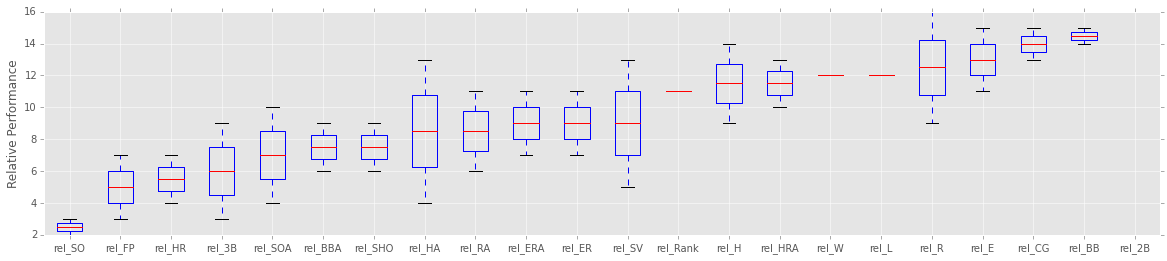

In [5]:
def relative_performance_during_stint(stint):
    """Returns a dictionary containing the average relative stats for team during a 
    manager's stint. This is different from a join because we are averaging the results 
    during the stint.
    stat -> [mean rel_position, std rel_position, values]"""
    stint_df = manager_stints_df[manager_stints_df.stintID == stint]
    
    firstYear = stint_df.iloc[0].firstYear
    lastYear  = stint_df.iloc[0].lastYear
    numYears  = stint_df.iloc[0].numYears
    teamID    = stint_df.iloc[0].teamID
    manager   = stint_df.iloc[0].playerID
    
    rel_perf_dict = {'teamID': teamID, 'manager': manager, 'firstYear': firstYear,
                     'lastYear': lastYear, 'numYears': numYears, 'stintID': stint}
    
    for key in team_stat.keys():
        rel_perf_dict['rel_' + key] = []
        
    # Get mean and std for each stat in the stint 
    for stat in team_stat.keys():
        statname = 'rel_' + stat
        stat_series = rel_teams_df[(rel_teams_df.teamID == teamID)     \
                                   & (rel_teams_df.yearID >= firstYear)\
                                   & (rel_teams_df.yearID <= lastYear)][statname]
        rel_perf_dict[statname] = [stat_series.mean(), 
                                   stat_series.std(), 
                                   stat_series.values]
    
    return rel_perf_dict

def ordered_rel_stint_performance(stint):
    """Orders the results of relative_performance_during_stint() into an ordered list 
    of tuples. (stat, mean, std)"""    
    perf_dict = relative_performance_during_stint(stint)
    # Create list of stat tuples
    rel_stats_list = []
    for stat in team_stat.keys():
        statname = 'rel_' + stat
        rel_stats_list.append((statname, 
                               perf_dict[statname][0], 
                               perf_dict[statname][1], 
                               perf_dict[statname][2]))
        
    rel_stats_list = sorted(rel_stats_list, key=lambda stat: stat[1])
    return rel_stats_list

def display_rel_stint_performance(stint):
    """Displays descriptive statistics for the relative performance of a stint."""
    perf_dict = relative_performance_during_stint(stint)
    rel_stats_list = ordered_rel_stint_performance(stint)
        
    out_str = 'stint  : ' + str(perf_dict['stintID'])   + '\n' +\
              'manager: ' + str(perf_dict['manager'])   + '\n' +\
              'team   : ' + str(perf_dict['teamID'])    + '\n' +\
              'start y: ' + str(perf_dict['firstYear']) + '\n' +\
              'end   y: ' + str(perf_dict['lastYear'])  + '\n' +\
              'num   y: ' + str(perf_dict['numYears'])  + '\n' +\
              '--------------------\n' + \
              '(stat, mean rank during stint, ' +\
              'std of rank during stint, list of actual values)\n' +\
              '\n'.join(map(str, rel_stats_list))
    
    print(out_str)
    show_box_plots_rel_stint_performance(stint)
    
def show_box_plots_rel_stint_performance(stint):
    """Displays box plots for the relative performance of each statistic during
    a stint."""
    perf_dict = relative_performance_during_stint(stint)
    rel_stats_list = ordered_rel_stint_performance(stint)
    data = []
    labels = []
    for (stat, mean, std, series) in rel_stats_list:
        data.append(series)
        labels.append(stat)
    plt.boxplot(data, labels=labels)
    plt.ylabel("Relative Performance")
    plt.gcf().set_figwidth(20)
    plt.show()

display_rel_stint_performance(np.random.randint(1, len(manager_stints_df)))
# stint 521 is interesting to look at

#### 6. Manager Transitions
We want to get the transitions between consecutive manager stints so that we can compare the relative performance of the manager's team before and after the transition. The result of this step will be a list of managers with their before stint and after stint.

We limit the transitions with the following conditions: 
- There must be a before and after stint (there is not a transition from before a manger's career to the manager's first stint, likewise for the end of the manager's career). We want to be able to compare statistics between the before and after stints but this is impossible in either of these scenarios.
- The last year of the first stint and the first year of the second stint must be consecutive years. We are not considering 'gaps' in the manager's career, only consecutive year switches. We want to minimize the potential differences between the two stints.
- Both the before and after stint must be at least 2 years in length. We would like to compare the standard deviation of aggregate team statistics between the two stints, however stints that are only 1 year do not produce a useful standard deviation.

In [6]:
def manager_transitions(enforce_consecutive_rule=True, 
                        min_years_in_stint=2,
                        enforce_equal_years=False):
    """Returns a DataFrame which contains the stint transitions for each manager.
    columns: 'playerID', 'firstStint', 'secondStint'"""
    manager_transitions = {'playerID': [], 'firstStint': [], 'secondStint': []}
    
    for manager in pd.unique(manager_stints_df.playerID.ravel()):
        manager_career_df = manager_stints_df[manager_stints_df.playerID == manager].\
                                sort_values('firstYear')
            
        for i in range(1, len(manager_career_df)):
            previous_stint_last_year = manager_career_df.iloc[i-1].lastYear
            current_stint_first_year = manager_career_df.iloc[i].firstYear
            
            first_stint = manager_career_df.iloc[i-1].stintID
            second_stint = manager_career_df.iloc[i].stintID
            
            first_stint_length = manager_career_df.iloc[i-1].numYears
            second_stint_length = manager_career_df.iloc[i].numYears
            
            pass_consecutive_rule = True
            if enforce_consecutive_rule:
                pass_consecutive_rule = \
                    (previous_stint_last_year + 1) == current_stint_first_year
                    
            pass_num_year_rule = (first_stint_length >= min_years_in_stint) and \
                                 (second_stint_length >= min_years_in_stint)
                
            pass_equal_years_rule = True
            if enforce_equal_years:
                pass_equal_years_rule = (first_stint_length == second_stint_length)
            
            if (pass_consecutive_rule and pass_num_year_rule and pass_equal_years_rule):
                manager_transitions['playerID'].append(manager)
                manager_transitions['firstStint'].append(first_stint)
                manager_transitions['secondStint'].append(second_stint)
            
    return pd.DataFrame(data=manager_transitions)

manager_transitions_df = manager_transitions()
print(manager_transitions_df)

    firstStint   playerID  secondStint
0            1  wrighha01            2
1            2  wrighha01            3
2            3  wrighha01            4
3           67  barnibi01           68
4           72  phillho99           73
5           75  mutriji99           76
6           95  loftuto01           96
7          128  seleefr99          129
8          132   wardjo01          133
9          139  hanlone01          140
10         140  hanlone01          141
11         167  clarkfr01          168
12         178  griffcl01          179
13         180  griffcl01          181
14         183  mcaleji01          184
15         192  armoubi99          193
16         240  huggimi01          241
17         256  moranpa01          257
18         262  mitchfr01          263
19         287  mckecbi01          288
20         290  harribu01          291
21         295  harribu01          296
22         308  howleda01          309
23         328  cronijo01          329
24         370  southbi01

#### 7. Relative Statistic Differences Between Stints


In [7]:
def diff_between_stints(stint1, stint2):
    """Returns a dictionary containing the mean and std difference of relative stat 
    performance between the two stints."""
    diff_dict = {}
    stint1_perf = relative_performance_during_stint(stint1)
    stint2_perf = relative_performance_during_stint(stint2)

    for stat in team_stat.keys():
        statname = 'rel_' + stat
        mean_diff = stint2_perf[statname][0] - stint1_perf[statname][0]
        std_diff = stint2_perf[statname][1] - stint1_perf[statname][1]
        diff_dict['d_mean_' + stat] = mean_diff

    return diff_dict

def diff_df(transitions_df):
    """Returns a DataFrame containing the difference in relative statistical 
    performance (mean and std) between two stints for each manger transition in 
    transitions_df."""
    trans_diff_dict = {}
    for stat in team_stat.keys():
        trans_diff_dict['d_mean_' + stat] = []

    for i in range(0, len(transitions_df)):
        stint1 = transitions_df.iloc[i].firstStint
        stint2 = transitions_df.iloc[i].secondStint
        diff_dict = diff_between_stints(stint1, stint2)

        for stat in diff_dict.keys():
            trans_diff_dict[stat].append(diff_dict[stat])

    return pd.DataFrame(data=trans_diff_dict)

def merge_transitions_df_w_stats(transitions_df, transition_stats_df):
    """Returns a transitions DataFrame which is merged with another
    DataFrame containing descriptive statistics for each transition."""
    return pd.merge(transitions_df, 
                    transition_stats_df, 
                    left_index=True, 
                    right_index=True)

manager_transitions_w_stats_df = \
    merge_transitions_df_w_stats(manager_transitions_df, 
                                 diff_df(manager_transitions_df))
manager_transitions_w_stats_no_consecutive_df = \
    merge_transitions_df_w_stats(manager_transitions_df,
                                 manager_transitions(min_years_in_stint=2))
print(manager_transitions_w_stats_df)

    firstStint   playerID  secondStint  d_mean_2B  d_mean_3B  d_mean_BB  \
0            1  wrighha01            2   2.000000   2.066667   1.266667   
1            2  wrighha01            3   0.500000   2.333333   4.333333   
2            3  wrighha01            4   3.500000   8.000000   1.833333   
3           67  barnibi01           68   8.500000   6.142857   8.571429   
4           72  phillho99           73   1.500000   9.500000   8.000000   
5           75  mutriji99           76  -3.285714  -1.928571   3.714286   
6           95  loftuto01           96  -1.000000  -4.000000   5.000000   
7          128  seleefr99          129   5.250000   1.166667   3.416667   
8          132   wardjo01          133   4.500000  -2.500000   2.000000   
9          139  hanlone01          140   3.523810   3.238095   1.642857   
10         140  hanlone01          141   6.642857  -6.071429   1.357143   
11         167  clarkfr01          168   0.375000  -5.875000   1.062500   
12         178  griffcl01

### Explore
Now that we have our data organized, we are ready to start looking for patterns in the data. 

Our starting question was: When a manager transfers teams, does the relative performance of any team statistic from the manager's previous team transfer to the manager's new team?

First, we can modify step 7 so that we test for a significant statistical difference in each relative statistic between the before and after stints for each transition. Normally, we would use a t test to do this, however we are not certain that our data is normally distributed, which is required for an independent samples t test. Instead we can use the Wilcoxon rank sum test, which produces a t statistic and p value for non parametric data. Similar to a t test, if the returned p value is less than the chosen alpha, we can say that the mean difference of the two sets differed significantly. We can then generate a list of stats for each transition in which the statistics differ significantly between the before and after stints in the transition.

However this approach only answers our question of which statistics transfer along with the manager in a roundabout way. The results would show which statistics did not transfer between teams, which has some valuable meaning, but does not show which statistics do transfer between teams. 

It would also be appropriate to test the reverse, answering the question of which statistics stay significantly the same between the before and after stint for a transition. As presented by Harvey Molusky, one way to test for equivalence is by comparing the 95% confidence intervals of the two sets. If both 95% confidence intervals fall below a given threshold, they are considered the same. In our case, we will choose the threshold to be 1 because we are comparing the relative placement of statistics, in which a difference of less than 1 would not occur in any given year (unless they have the same place, in which case they are truly equivalent). Because we cannot assume the data sets are normally distributed, determining the confidence interval becomes more difficult. In order to create a confidence interval for this non-normally distributed data, we use bootstrapping as defined in (Scheiner, Gurevitch, 1999) and implemented in the scikit-bootstrap python library.

An alternative approach to equivalency testing with non parametric data is defined in Meier (2010) in which a Wilcoxon sum rank test is used in substitution for the independent samples t test in a TOST (two one-sided t) equivalency test. This approach will not be explored in this paper but it would be interesting to compare the results generated with this approach against the results generated from the confidence interval approach.

Finally, using the output DataFrame of step 7 which includes the difference in performance for each stat for each transition, we can look for overall trends between team statistics.

#### 1. Which statistics are significantly different?

In [8]:
def ranksum_test_between_stints(stint1, stint2):
    """Returns a dictionary containing the output of a Wilcoxon rank sum test for 
    every statistic between the two stints.
    {t_rel_W: tstat, p_rel_W: pval, ...} 
    """
    t_dict = {}
    stint1_perf = relative_performance_during_stint(stint1)
    stint2_perf = relative_performance_during_stint(stint2)

    for stat in team_stat.keys():
        statname = 'rel_' + stat
        stint1_stat_values = stint1_perf[statname][2]
        stint2_stat_values = stint2_perf[statname][2]
        
        ttestresults = stats.ranksums(stint1_stat_values, stint2_stat_values)
            
        t_dict['t_rel_' + stat] = ttestresults[0] # t-statistic
        t_dict['p_rel_' + stat] = ttestresults[1] # p-value

    return t_dict

def ranksum_diff_df(transitions_df):
    """Returns a DataFrame containing the results (t and p values) of a independent 
    samples t test for each statistic for each row in the input transitions_df table. 
    The t test compares two independent samples, the relative performances for a 
    statistic before the transition and the relative performances for a statistic after 
    the transition. The null hypothesis is that the mean difference between the two 
    statistics is 0. The alternate hypothesis is that the mean difference between the 
    two statistics is not 0. The output of this function should be merged with a 
    transitions table."""
    t_dict = {}
    for stat in team_stat.keys():
        t_dict['t_rel_' + stat] = []
        t_dict['p_rel_' + stat] = []

    for i in range(0, len(transitions_df)):
        stint1 = transitions_df.iloc[i].firstStint
        stint2 = transitions_df.iloc[i].secondStint
        t_stint_dict = ranksum_test_between_stints(stint1, stint2)

        for stat in t_stint_dict.keys():
            t_dict[stat].append(t_stint_dict[stat])

    return pd.DataFrame(data=t_dict)

ranksum_manager_transitions = manager_transitions(min_years_in_stint=3)

manager_transitions_w_ranksum_df = \
    merge_transitions_df_w_stats(
        ranksum_manager_transitions, ranksum_diff_df(ranksum_manager_transitions))
    
print(manager_transitions_w_ranksum_df)

    firstStint   playerID  secondStint  p_rel_2B  p_rel_3B  p_rel_BB  \
0            1  wrighha01            2  0.022479  0.082837  0.465209   
1          128  seleefr99          129  0.071197  0.563703  0.312321   
2          139  hanlone01          140  0.116083  0.253098  0.668235   
3          180  griffcl01          181  0.781511  0.016230  0.116032   
4          240  huggimi01          241  0.014863  0.820753  0.001837   
5          256  moranpa01          257  0.014306  0.014306  0.540291   
6          262  mitchfr01          263  0.033895  0.479500  0.288844   
7          287  mckecbi01          288  0.001948  0.792896  0.293622   
8          290  harribu01          291  0.391267  0.624206  0.050044   
9          308  howleda01          309  0.049535  0.382733  0.049535   
10         370  southbi01          371  0.765594  0.036888  0.550985   
11         398  lopezal01          399  0.262890  0.021556  0.555690   
12         410  alstowa01          411  0.033325  0.966050  0.01

Percentage of stats covered: 100.0%


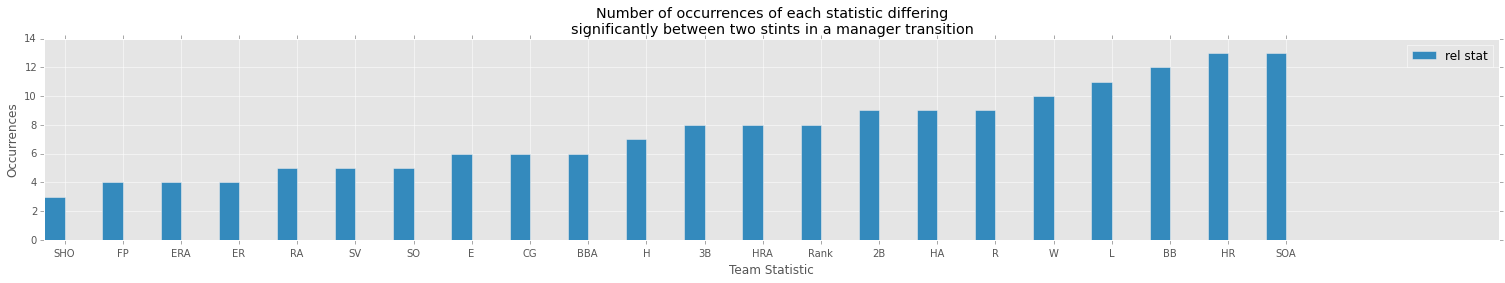

In [9]:
def find_significant_differences(transitions_w_stat_df):
    """Return a dictionary containing the stats for each manager which differed
    significantly between the before and after stints of a manager transition.
    transition_index -> [stat1, stat2, ...]"""
    stat_dict = {}
    for i in range(0, len(transitions_w_stat_df)):
        stat_dict[i] = []
    for i in range(0, len(transitions_w_stat_df)):
        for stat in team_stat.keys():
            statname = "p_rel_" + stat
            p_value = transitions_w_stat_df.iloc[i][statname]
            if p_value < 0.05:
                stat_dict[i].append(stat)
    return stat_dict

def count_occurrences(stat_dict):
    """Transforms the input dictionary from transition_index -> [stat1, stat2, ...] to
    stat1 -> num_occurences_of_stat1. This will help us look for patterns in the
    stat_dict data."""
    occ_dict = {}
    for transition_index in stat_dict.keys():
        for stat in stat_dict[transition_index]:
            if stat not in occ_dict.keys():
                occ_dict[stat] = 1
            else:
                occ_dict[stat] += 1
    return occ_dict

def get_percent_stat_coverage(occ_dict):
    """Returns the percentage of team stats that appear in the given occ_dict."""
    total_num_stats = len(team_stat.keys())
    num_stats_occurred = len(occ_dict.keys())
    return num_stats_occurred / float(total_num_stats)

def order_dictionary_based_on_value(d):
    """Returns an ordered dictionary based on the values of the dictionary."""    
    return collections.OrderedDict(sorted(d.items(), key=lambda t: t[1]))
    
def show_bar_graph_from_dict(in_dict, title):
    """Creates a bar graph from the input dictionary in_dict."""
    if len(in_dict.keys()) == 0:
        return
    ordered_dict = order_dictionary_based_on_value(in_dict)
    labels = ordered_dict.keys()
    values = []
    for key in ordered_dict.keys():
        values.append(ordered_dict[key])
        
    n_groups = len(labels)

    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.35

    rects1 = plt.bar(index, values, bar_width,
                     label='rel stat')

    plt.xlabel('Team Statistic')
    plt.ylabel('Occurrences')
    plt.title(title)
    plt.xticks(index + bar_width, labels)
    plt.legend()
    plt.gcf().set_figwidth(21)
    plt.tight_layout()
    plt.show()
    
occurrences_of_significantly_different_stats = \
    count_occurrences(find_significant_differences(manager_transitions_w_ranksum_df))
    
print("Percentage of stats covered: " + 
  str(get_percent_stat_coverage(occurrences_of_significantly_different_stats) * 100) +
     '%')

#print(occurrences_of_significantly_different_stats)

show_bar_graph_from_dict(occurrences_of_significantly_different_stats, 
                         "Number of occurrences of each statistic differing \n" + 
                         "significantly between two stints in a manager transition")

#### 2. Which statistics remain significantly the same? (bootstrap confidence interval approach)

In [10]:
def ci_for_each_stat_between_stints(stint1, stint2):
    """Returns a dictionary containing the 95% confidence interval for the 
    relative performance of each team statistic for both stints in the transition.
    The confidence interval is calculated using a bootstrapping method in which we
    resample the set of relative performances for a statistic in a stint, with 
    replacement, 10,000 times and derive the confidence interval from the 
    resulting distribution."""
    t_dict = {}
    stint1_perf = relative_performance_during_stint(stint1)
    stint2_perf = relative_performance_during_stint(stint2)

    for stat in team_stat.keys():
        statname = 'rel_' + stat
        stint1_stat_values = stint1_perf[statname][2]
        stint2_stat_values = stint2_perf[statname][2]
        
        stint1_ci = bootstrap.ci(data=stint1_stat_values)
        stint2_ci = bootstrap.ci(data=stint2_stat_values)
            
        t_dict['stint1_low_' + stat]  = stint1_ci[0] # stint1 low
        t_dict['stint1_high_' + stat] = stint1_ci[1] # stint1 high
        t_dict['stint2_low_' + stat]  = stint2_ci[0] # stint2 low
        t_dict['stint2_high_' + stat] = stint2_ci[1] # stint2 high

    return t_dict

def ci_diff_df(transitions_df):
    """Returns a DataFrame containing the 95% confidence interval for the 
    relative performance of each statistic for both stints in a transition."""
    ci_dict = {}
    for stat in team_stat.keys():
        ci_dict['stint1_low_' + stat]  = []
        ci_dict['stint1_high_' + stat] = []
        ci_dict['stint2_low_' + stat]  = []
        ci_dict['stint2_high_' + stat] = []

    for i in range(0, len(transitions_df)):
        stint1 = transitions_df.iloc[i].firstStint
        stint2 = transitions_df.iloc[i].secondStint
        ci_stint_dict = ci_for_each_stat_between_stints(stint1, stint2)

        for stat in ci_stint_dict.keys():
            ci_dict[stat].append(ci_stint_dict[stat])

    return pd.DataFrame(data=ci_dict)

manager_transitions_w_ci_df = \
    merge_transitions_df_w_stats(
        ranksum_manager_transitions, ci_diff_df(ranksum_manager_transitions))
    
print(manager_transitions_w_ci_df)

    firstStint   playerID  secondStint  stint1_high_2B  stint1_high_3B  \
0            1  wrighha01            2        1.000000        1.800000   
1          128  seleefr99          129        9.000000       12.500000   
2          139  hanlone01          140        7.166667        8.500000   
3          180  griffcl01          181       13.000000        5.333333   
4          240  huggimi01          241       20.000000       13.800000   
5          256  moranpa01          257        5.000000       22.000000   
6          262  mitchfr01          263        9.750000       13.000000   
7          287  mckecbi01          288       15.750000       13.750000   
8          290  harribu01          291       10.600000        5.000000   
9          308  howleda01          309       10.000000       13.666667   
10         370  southbi01          371        3.800000        7.400000   
11         398  lopezal01          399       12.833333       15.333333   
12         410  alstowa01          411

In [11]:
def find_significant_sameness(transitions_w_ci_df, tol=1):
    """Return a dictionary containing the stats for each transition_index which are 
    significantly the same between the before and after stints of a manager transition.
    The statistic is considered significantly the same between stints when both 
    confidences fall within the chosen tolerance of each other.
    transition_index -> [stat1, stat2, ...]"""
    stat_dict = {}
    for i in range(0, len(transitions_w_ci_df)):
        stat_dict[i] = []
    for i in range(0, len(transitions_w_ci_df)):
        for stat in team_stat.keys():
            stint1_low = transitions_w_ci_df.iloc[i]['stint1_low_' + stat]
            stint1_high = transitions_w_ci_df.iloc[i]['stint1_high_' + stat]
            stint2_low = transitions_w_ci_df.iloc[i]['stint2_low_' + stat]
            stint2_high = transitions_w_ci_df.iloc[i]['stint2_high_' + stat]
            
            center_ci_1 = (stint1_low + stint1_high) / 2.
            center_ci_2 = (stint2_low + stint2_high) / 2.
            center = (center_ci_1 + center_ci_2)/2.
            
            if center + tol/2. > stint1_high and center + tol/2. > stint2_high and \
               center - tol/2. < stint1_low  and center - tol/2. < stint2_low :
                    stat_dict[i].append(stat)
                
    return stat_dict

occurrences_of_significantly_same_stats = \
    count_occurrences(find_significant_sameness(manager_transitions_w_ci_df,
                                                tol=1))
    
print("Percentage of stats covered: " + 
  str(get_percent_stat_coverage(occurrences_of_significantly_same_stats) * 100) +
     '%')

show_bar_graph_from_dict(
    occurrences_of_significantly_same_stats, 
    "Number of occurrences of each statistic remaining \n" + 
    "significantly similar between two stints in a manager transition")

Percentage of stats covered: 0.0%


#### 3. What is the average difference in relative performance for each team statistic between manager stints?

Mean differences for all stats: 
d_mean_SO       -1.083463
d_mean_CG       -0.271322
d_mean_3B       -0.030472
d_mean_E         0.110672
d_mean_HRA       0.224887
d_mean_2B        0.555006
d_mean_H         0.569807
d_mean_FP        0.605587
d_mean_HA        0.662431
d_mean_ER        0.709647
d_mean_RA        0.790292
d_mean_L         1.029462
d_mean_ERA       1.242939
d_mean_SOA       1.319611
d_mean_W         1.353184
d_mean_SHO       1.586991
d_mean_Rank      1.597571
d_mean_R         1.862793
d_mean_HR        1.884174
d_mean_SV        1.959672
d_mean_BBA       2.023681
d_mean_BB        2.060805
firstStint     412.379310
secondStint    413.379310
dtype: float64


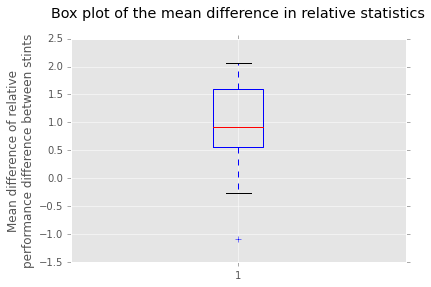

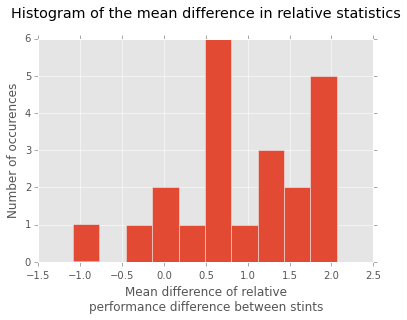

In [12]:
print("Mean differences for all stats: ")
print(manager_transitions_w_stats_df.mean().sort_values())

data = manager_transitions_w_stats_df.mean().sort_values()
out_data = []
for i in range(0,len(data)-2):
    out_data.append(data[i])

plt.title("Box plot of the mean difference in relative statistics\n")
plt.ylabel("Mean difference of relative \nperformance difference between stints")
plt.boxplot(out_data)
plt.show()

plt.title("Histogram of the mean difference in relative statistics\n")
plt.ylabel("Number of occurences")
plt.xlabel("Mean difference of relative \nperformance difference between stints")
plt.hist(out_data)
plt.show()

### Conclusion
In our first area of exploration, we sought to answer the question of which team statistics differed significantly between stints during a transition. This question is scoped for a single transition. The results can then be aggregated over all transitions and we can search for trends in the number of occurrences of each team statistic being significantly different between stints.

For each statistic for each transition, we ran a Wilcoxon rank sum test (alpha=0.05) to test for a significant difference between the relative performance of the chosen team statistic between the two stints in the transition. We used the Wilcoxon rank sum test instead of an independent samples t test because we could not assume that the set of relative performances of a team statistic for a given stint were normally distributed. In our Wilcoxon rank sum test, we took our null hypothesis to be that the mean difference in relative performance for a team statistic between the before and after stints was equal to 0. The alternative hypothesis is that the difference in relative performance for a team statistic between the before and after stints was not equal to 0.

The results showed that each transition had it's own unique set of team statistics that differed significantly. No team statistic significantly differed in every transition. When the results were aggregated over all transitions, we saw that the team's relative number of HR and SOA significantly differed the most often during a transition, albeit this does not seem to be a strong trend because significant difference in relative performance of HR and SOA only occurred in 13 of the potential 28 transitions (46.4%).

In our second area of exploration, we sought to answer the question of which team statistics remained significantly the same between stints during a transition. This question is not simply the opposite of the first area of exploration because failing to reject the null hypothesis does not imply that the null hypothesis is correct. Instead, we tested for equivalency by comparing the 95% confidence interval for both the relative performance of a team statistic before the transition and the relative performance of a team statistic after the transition. We found the midpoint of the centers of the two confidence intervals and applied half the tolerance in the positive and negative directions to create our zone of indifference. If both confidence intervals fell within the zone of indifference, we took the results to be equivalent. We chose the tolerance to be 1 because (individually) ranks are integer based and two ranks within 1 would imply equality. Determining a confidence interval for the relative performance for a statistic in a stint is not trivial because the data is not necessarily normally distributed. In order to create a 95% confidence interval, we bootstrapped (sampling with replacement, n=10,000) each statistic for both stints for each transition.

The results returned no team statistics that remained significantly equivalent between the before and after stints of a transition, given the chosen tolerance. This could be attributed in part to the small sets of data, considering that the overall average manager stint duration is only 2 years (in our exploration we only look at transitions in which both stint durations are at least 3 years). As we increase the equivalency tolerance, the number of equivalent statistics increases as can be shown in the appendix on the graph "The effect of threshold on percentage of team statistic occurrences when testing for relative statistic performance equivalence between stints". However, the equivalency results are less meaningful when the tolerance is increased beyond the chosen threshold. Given our results in this area of exploration, it seems unlikely that any manager's relative performance of any particular team statistic will carry over to the new stint.

In our third area of exploration, we looked for trends in overall differences between the before and after stints. To do this, we found the means of the mean difference in relative performance between the before and after stint for every statistic for every transition. In general it appears that the data is negatively skewed with 1 outlier in the negative direction. The results show that on average the difference in relative performance is positive, meaning that the relative performance of the statistic was worse in the second stint than in the first stint.

#### Areas for further research
After completing this paper there are two areas of exploration that can expand upon our results. The first would be to better understand the distribution of relative performance of each statistic for a given stint. This would potentially allow us to use a different test other than the Wilcoxon rank sum test for determining significant differences in performance. Likewise, it might allow for easier computation of a TOST test for determining equivalency between stint statistical performance. Perhaps using alternative tests would produce stronger, more refined results.

Additionally, our third area of exploration brought about the question of whether or not it is better to hire first time managers vs veteran managers with a transition history. In our paper, we only looked at managers which transitioned from one team to another and did not look at first time managers. With most team statistics performing on average worse in the second stint than the first, perhaps it is better to start with a new manager rather than one which on average will worsen team statistics.

### References

Bradbury, J. C. (2006), “Hired to Be Fired: The Publicity Value of Managers,” unpublished
manuscript, Kennesaw State University.

Geyer, C. J. (2003, April 13). Nonparametric Tests and Confidence Intervals. 
Retrieved February 29, 2016. [link](http://www.stat.umn.edu/geyer/old03/5102/notes/rank.pdf)

Lahman, Sean, comp. The Lahman Baseball Database. 2014 ed. [link](http://www.seanlahman.com/baseball-archive/statistics/)

Meier, U. (2010), Nonparametric equivalence testing with respect to the median difference. Pharmaceut. Statist., 9: 142–150. doi: 10.1002/pst.384. [link](http://onlinelibrary.wiley.com/doi/10.1002/pst.384/references)

Motulsky, Harvey. "Testing for Equivalence Is Not Just the opposite of Testing for Significant Differences." Statistical Tests for Equivalence. Web. 28 Feb. 2016. [link](http://web.archive.org/web/20120119090119/http://www.graphpad.com/library/BiostatsSpecial/article_182.htm)

Ruggiero, J., Hadley, L., Ruggiero, G., & Knowles, S.. (1997). A Note on the Pythagorean Theorem of Baseball Production. Managerial and Decision Economics, 18(4), 335–342. [link](http://www.jstor.org/stable/3108205)

Scheiner, Samuel M., and Jessica Gurevitch. Design and Analysis of Ecological Experiments. New York: Chapman and Hall, 1993. [link](https://www.researchgate.net/file.PostFileLoader.html?id=5495b4a6d4c118a2508b4612&assetKey=AS%3A273655584493572%401442255983418)

Silvers, Randy, and Susmel, Raul. "Compensation of a Manager: The Case of Major League Baseball." University of Houston, 1 Apr. 2014. Web. 14 Jan. 2016. [link](http://www.bauer.uh.edu/rsusmel/Academic/MLB Manager Salaries_1.pdf).

Wild, C. J., and G. A. F. Seber. Chance Encounters: A First Course in Data Analysis and Inference. New York: John Wiley, 2000. [link](http://www.stat.umn.edu/geyer/old03/5102/notes/rank.pdf)


### Appendix


In [13]:
# Descriptive statistics for the duration of a manager's stint
print("Manager Stint Duration")
manager_stints_df.numYears.describe()

Manager Stint Duration


count    801.000000
mean       2.897628
std        3.049919
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       36.000000
Name: numYears, dtype: float64

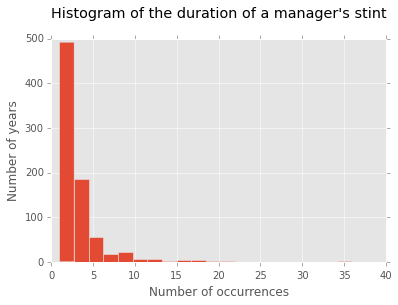

In [14]:
# Histogram of duration of a manager's stint
plt.title("Histogram of the duration of a manager's stint\n")
plt.ylabel("Number of years")
plt.xlabel("Number of occurrences")
plt.hist(manager_stints_df.numYears, bins=20)
plt.show()

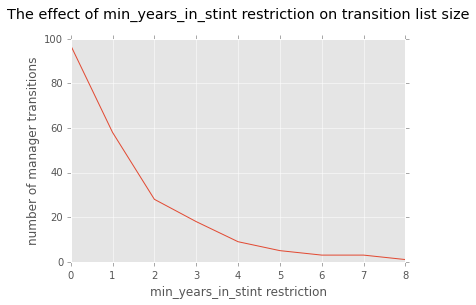

In [15]:
# The effect of min_years_in_stint restriction on transition list size
tmp_list = []
for i in range(1,10):
    tmp_list.append(len(manager_transitions(min_years_in_stint=i)))

plt.plot(tmp_list)
plt.title("The effect of min_years_in_stint restriction on transition list size\n")
plt.ylabel('number of manager transitions')
plt.xlabel('min_years_in_stint restriction')
plt.show()

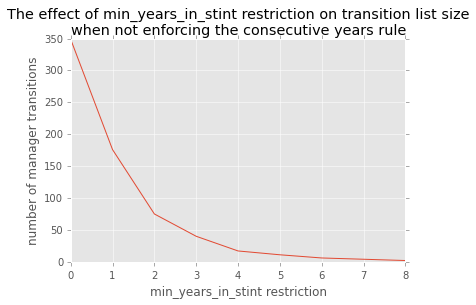

In [16]:
# The effect of min_years_in_stint restriction on transition list size when 
# not enforcing the consecutive rule
tmp_list = []
for i in range(1,10):
    tmp_list.append(len(manager_transitions(enforce_consecutive_rule=False,
                                            min_years_in_stint=i)))

plt.plot(tmp_list)
plt.title("The effect of min_years_in_stint restriction on transition list size\n" +\
          "when not enforcing the consecutive years rule")
plt.ylabel('number of manager transitions')
plt.xlabel('min_years_in_stint restriction')
plt.show()

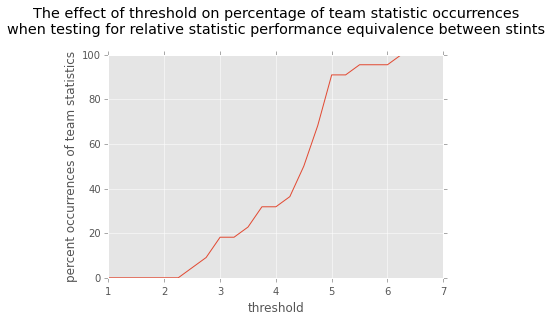

In [17]:
# The effect of loosening the threshold for statistical sameness
tmp_list = []
index = np.arange(1, 7, .25)
for i in index:
    occurrences_of_significantly_same_stats = \
        count_occurrences(find_significant_sameness(manager_transitions_w_ci_df,
                                                    tol=i))
    tmp_list.append(get_percent_stat_coverage(
            occurrences_of_significantly_same_stats) * 100)
plt.plot(index, tmp_list)
plt.title("The effect of threshold on percentage of team statistic occurrences\n" +
          "when testing for relative statistic performance equivalence between stints\n")
plt.ylabel('percent occurrences of team statistics')
plt.xlabel('threshold')
plt.show()